# Why pandas?

The `🐼.DataFrame` and `🐼.Series` `object`s provide [fluent interfaces](https://en.wikipedia.org/wiki/Fluent_interface) to compose complex actions that transform, visualize, and model data by [chaining](https://tomaugspurger.github.io/method-chaining).  

[![image](https://user-images.githubusercontent.com/4236275/46419595-3bac3580-c6fc-11e8-85c9-3ffe212c0021.png)](https://trestletech.com/wp-content/uploads/2015/07/dplyr.pdf#page=6)


To me, and some others, fluent interfaces are more readable than nested operations. 

[![image](https://user-images.githubusercontent.com/4236275/46419770-980f5500-c6fc-11e8-9cbd-a4ca0b830b6e.png)](https://tomaugspurger.github.io/method-chaining)

# About this demonstration

I believe one of the best ways to practice data analysis is to work with data you know.  Resources like your Facebook or Linkedin archives are great ways to explore your self as data.

Github is my favorite social platform so I thought that we could explore the Github API.

> [Let's look at an awesome notebook about Marta.](http://nbviewer.jupyter.org/github/amorrissette/Marta_ATL/blob/master/PyData_082018/PyData_MARTA_083018.ipynb)

In [1]:
    import pandas, asyncio, os, requests, datetime, typing as t, IPython
    from toolz.curried import *
    %matplotlib inline
    params = os.environ.get('gh') and {
        'access_token': os.environ.get('gh')
    } or {}

# Accessing data.

Pandas has a bunch of read methods that you should fully take advantage of.

In [2]:
    pipe(pandas, dir, filter(flip(str.startswith)('read_')), list, pandas.DataFrame).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,read_clipboard,read_csv,read_excel,read_feather,read_fwf,read_gbq,read_hdf,read_html,read_json,read_msgpack,read_parquet,read_pickle,read_sas,read_sql,read_sql_query,read_sql_table,read_stata,read_table


In [3]:
    frames = pandas.read_html("https://en.wikipedia.org/wiki/List_of_physical_quantities")
    f"There are __{len(frames)}__ tables in this webpage."

'There are __2__ tables in this webpage.'

> [Using list comprehensions to create dataframes.](https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/)

## Caching requests

Caching our requests assures that our data remains local and we can work with out the internet.  Simply install [`requests_cache`](https://github.com/reclosedev/requests-cache) and use `requests` naturally.

In [4]:
    import requests_cache; requests_cache.install_cache('idiomatic_pandas')

> Sometimes I use Python type annotations to indicate the input and output values of the functions.

In [5]:
    username = 'tonyfast'

> We could make this request with `pandas.read_json`, but we would not be using `requests_cache`.  

The code below returns information about a specific `username`.  This data includes urls to other endpoints and objects.

In [6]:
    info = pandas.read_json(
        requests.get(f"https://api.github.com/users/%s"%username, params=params).content,
        typ='Series'); info.to_frame()

,0
login,tonyfast
id,4236275
node_id,MDQ6VXNlcjQyMzYyNzU=
avatar_url,https://avatars3.githubusercontent.com/u/42362...
gravatar_id,
url,https://api.github.com/users/tonyfast
html_url,https://github.com/tonyfast
followers_url,https://api.github.com/users/tonyfast/followers
following_url,https://api.github.com/users/tonyfast/followin...
gists_url,https://api.github.com/users/tonyfast/gists{/g...


In [8]:
    IPython.display.Markdown(f"![]({info.avatar_url})")

![](https://avatars3.githubusercontent.com/u/4236275?v=4)

## Some utitlity statements.

Accessing historical data in github requires pagination. https://developer.github.com/v3/guides/traversing-with-pagination/

`paginate` appends `"?page=%i"` to the end of our Github API requests.  The prefered approach in `requests` would use the params keyword, but then our URLs are non-unique.

In [9]:
    def paginate(url: str, slice: slice=slice(1,3)) -> t.Generator:
        return (f"{url}?page={page}" for page in range(slice.start, slice.stop+1))

I don't have `datetime` for composing timestamps so I use `pandas.to_datetime`.  From the Github API, columns ending in "**_at**" are timestamps.

In [10]:
    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

🐼 can deal with changes in time; `pandas.to_timedelta` helps with Δt.

In [11]:
    pandas.to_timedelta('1 days 10 seconds')

Timedelta('1 days 00:00:10')

and the difference between timestamps returns a time delta.

In [12]:
    Δt = pandas.Series([info.created_at, info.updated_at]).pipe(pandas.to_datetime).diff().dropna(); Δt

1   1987 days 02:19:37
dtype: timedelta64[ns]

`get` asynchronously makes web requests; these requests can occur concurrently and save time during development.

In [13]:
    async def request(url, params={}, headers={}) -> t.Union[pandas.Series, pandas.DataFrame]: 
        result = requests.get(url, params={
            **params, 'access_token': os.environ.get('gh')
        }, headers=headers).content
        try: return pandas.read_json(result)
        except ValueError: return pandas.read_json(result, typ=pandas.Series)

## Let's talk about me

We will use the contents of `info` to access information about the projects repositories, gists, stars, and events for the use of interest.

In [14]:
    repos = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.repos_url, slice(1, info.public_repos//30+1))))
    ).set_index('id').pipe(timify)
    f"""There have __{len(repos)}__ repositories associated with [__@{info.login}'s__]({info.html_url}) account after __>{Δt[1].days//365}__ years."""

"There have __157__ repositories associated with [__@tonyfast's__](https://github.com/tonyfast) account after __>5__ years."

In [15]:
    events = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.events_url.format(**{'/privacy': ''}), slice(1, 10))))
    ).set_index('id').pipe(timify)

>  __🐼 + `async` + Caching = 💪__

[Github gists](https://developer.github.com/v3/gists/)

In [22]:
    gists = pandas.concat(
        await asyncio.gather(*map(
            request, 
            paginate(info.gists_url.format(**{'/gist_id': ''}), slice(1, info.public_gists//30+1))
        ))
    ).set_index('id').pipe(timify)
    f"""{username} made __{len(gists)}__ gists during that time."""

'tonyfast made __514__ gists during that time.'

[Starred repositories](https://developer.github.com/v3/activity/starring/)

In [23]:
    stars = pandas.concat(
        await asyncio.gather(*map(
            partial(request, headers={
                'Accept': "application/vnd.github.v3.star+json"
            }), paginate(
                info.starred_url.format(**{'/owner': '', '/repo': ''}), slice(1, 700//30+1))
        ))
    ).pipe(
        lambda df: pandas.concat([df.repo.apply(pandas.Series), df.starred_at], axis=1)
    ).pipe(timify).set_index('id')
    f"""{username} starred __{len(stars)}__ repositories, too."""

'tonyfast starred __702__ repositories, too.'

"A look at __tonyfast's__ last __300__ events.'"

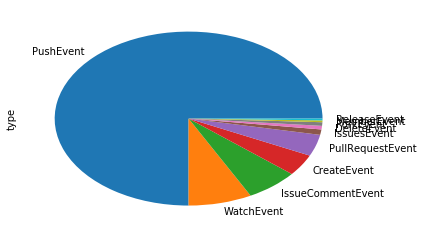

In [24]:
    events.type.value_counts().plot.pie()
    f"""A look at __{username}'s__ last __300__ events.'"""

In [25]:
    from matplotlib_venn import *; from toolz.curried.operator import *

How do the columns in the repos and stars compare.

'The __10__ overlapping columns are: __commits_url, node_id, created_at, html_url, updated_at, comments_url, forks_url, description, owner, url__'

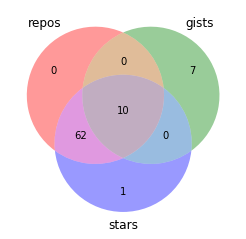

In [26]:
    pipe((repos, gists, stars), map(attrgetter('columns')), map(set), list, 
         partial(venn3_unweighted, set_labels=('repos', 'gists', 'stars')))

    intersections = set(repos.columns).intersection(gists.columns).intersection(stars.columns)
    f"The __{len(intersections)}__ overlapping columns are: __{', '.join(intersections)}__"

## Aggregations

`pandas.DataFrame.groupby` & `pandas.DataFrame.rolling` aggregations

> [Apply Functions By Group In Pandas
](https://chrisalbon.com/python/data_wrangling/pandas_apply_function_by_group/)

Lets join the `gists` and `repo` frames into `monthly_actions`.

In [35]:
    monthly_actions = repos.set_index('created_at')[[]].join(
        gists.set_index('created_at')[[]]
    ).join(
        stars.set_index('created_at')[[]]
    ).sort_index().index.to_frame().groupby(
        pandas.Grouper(freq='M')
    ).count()['created_at'].rename('created')

A look at the keys on the index of `monthly_actions`

In [36]:
    pandas.Series(dir(monthly_actions.index))[::-1].to_frame().T

,390,389,388,387,386,385,384,383,382,381,...,9,8,7,6,5,4,3,2,1,0
0,year,where,weekofyear,weekday_name,weekday,week,view,values,value_counts,unique,...,__class__,__bytes__,__bool__,__array_wrap__,__array_priority__,__array__,__and__,__add__,__abs__,T


Plotting the `monthly_events`

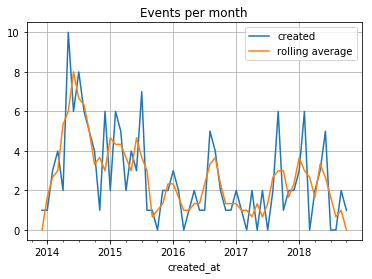

In [37]:
    ax = monthly_actions.plot(title='Events per month', legend=True)
    monthly_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True, grid=True)

In [38]:
        pandas.Index.to_series, pandas.Index.to_frame, pandas.Index.to_native_types

(<function pandas.core.indexes.base.Index.to_series(self, index=None, name=None)>,
 <function pandas.core.indexes.base.Index.to_frame(self, index=True)>,
 <function pandas.core.indexes.base.Index.to_native_types(self, slicer=None, **kwargs)>)

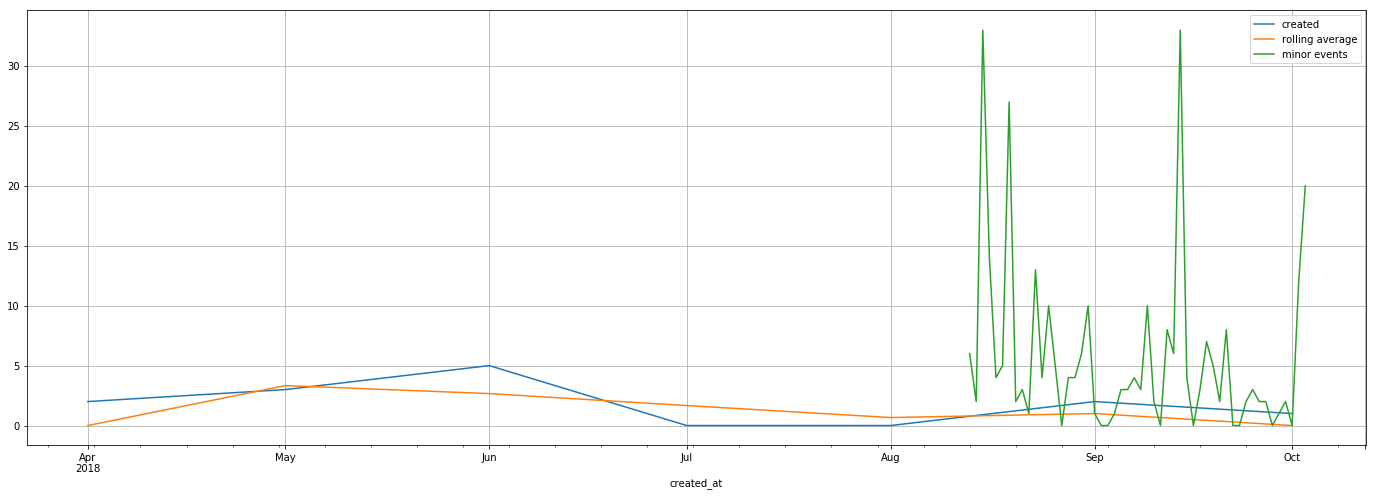

In [39]:
    this_years_actions = monthly_actions[
        monthly_actions.index > pandas.to_datetime('2018-04-01')]
    ax = this_years_actions.plot(title='Events per month', legend=True, figsize=(24, 8), grid=True)
    this_years_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True)
    events.set_index('created_at').index.to_frame().groupby(
        pandas.Grouper(freq='1D')
    ).count()['created_at'].rename('minor events').plot(ax=ax, legend=True, grid=True)

Let's go back to our gist and explore the languages each of them use.

In [43]:
    gists.sample(2)

,comments,comments_url,commits_url,created_at,description,files,forks_url,git_pull_url,git_push_url,html_url,node_id,owner,public,truncated,updated_at,url,user
id,,,,,,,,,,,,,,,,,
eccef54d264405987dee3e14bf5b5178,0,https://api.github.com/gists/eccef54d264405987...,https://api.github.com/gists/eccef54d264405987...,2017-09-13 18:13:37,A pathlib index,{'Untitled2.ipynb': {'filename': 'Untitled2.ip...,https://api.github.com/gists/eccef54d264405987...,https://gist.github.com/eccef54d264405987dee3e...,https://gist.github.com/eccef54d264405987dee3e...,https://gist.github.com/eccef54d264405987dee3e...,MDQ6R2lzdGVjY2VmNTRkMjY0NDA1OTg3ZGVlM2UxNGJmNW...,"{'login': 'tonyfast', 'id': 4236275, 'node_id'...",True,False,2017-09-13 18:57:11,https://api.github.com/gists/eccef54d264405987...,NaN
8aa8a14500c50344efba,0,https://api.github.com/gists/8aa8a14500c50344e...,https://api.github.com/gists/8aa8a14500c50344e...,2016-02-18 04:57:37,,{'travis-api.ipynb': {'filename': 'travis-api....,https://api.github.com/gists/8aa8a14500c50344e...,https://gist.github.com/8aa8a14500c50344efba.git,https://gist.github.com/8aa8a14500c50344efba.git,https://gist.github.com/8aa8a14500c50344efba,MDQ6R2lzdDhhYThhMTQ1MDBjNTAzNDRlZmJh,"{'login': 'tonyfast', 'id': 4236275, 'node_id'...",True,False,2016-02-18 04:58:28,https://api.github.com/gists/8aa8a14500c50344efba,NaN


Expanding `pandas.Series` with the apply method.

In [48]:
    gist = (
        gists.files
        .apply(pandas.Series)
        .stack(level=0)
        .apply(pandas.Series)
        .join(gists)
        .reset_index(-1, drop=True))

    gist.sample(2)

,filename,type,language,raw_url,size,comments,comments_url,commits_url,created_at,description,...,git_pull_url,git_push_url,html_url,node_id,owner,public,truncated,updated_at,url,user
id,,,,,,,,,,,,,,,,,,,,,
59f1bf0cdf3a3808b7e9ca0db1a923bb,tricks.yaml,text/x-yaml,YAML,https://gist.githubusercontent.com/tonyfast/59...,382,0,https://api.github.com/gists/59f1bf0cdf3a3808b...,https://api.github.com/gists/59f1bf0cdf3a3808b...,2017-04-05 13:40:25,,...,https://gist.github.com/59f1bf0cdf3a3808b7e9ca...,https://gist.github.com/59f1bf0cdf3a3808b7e9ca...,https://gist.github.com/59f1bf0cdf3a3808b7e9ca...,MDQ6R2lzdDU5ZjFiZjBjZGYzYTM4MDhiN2U5Y2EwZGIxYT...,"{'login': 'tonyfast', 'id': 4236275, 'node_id'...",True,False,2017-04-05 13:40:25,https://api.github.com/gists/59f1bf0cdf3a3808b...,NaN
787068bcafc5865fbf46,Yahoo-Finanace.ipynb,text/plain,Jupyter Notebook,https://gist.githubusercontent.com/tonyfast/78...,4075,0,https://api.github.com/gists/787068bcafc5865fb...,https://api.github.com/gists/787068bcafc5865fb...,2015-06-10 23:22:25,Yahoo Finance Notebook,...,https://gist.github.com/787068bcafc5865fbf46.git,https://gist.github.com/787068bcafc5865fbf46.git,https://gist.github.com/787068bcafc5865fbf46,MDQ6R2lzdDc4NzA2OGJjYWZjNTg2NWZiZjQ2,"{'login': 'tonyfast', 'id': 4236275, 'node_id'...",True,False,2015-08-29 14:22:53,https://api.github.com/gists/787068bcafc5865fbf46,NaN


In [52]:
    languages = (
        gist.set_index('created_at')
        .language
        .groupby(pandas.Grouper(freq='1Y'))
        .value_counts()
        .unstack()
        .pipe(lambda df: df.set_index(df.index.year))
    )
    languages.sample(2)

language,CSS,CSV,CoffeeScript,Graphviz (DOT),HTML,JSON,JavaScript,Jupyter Notebook,Limbo,Markdown,Matlab,Python,SVG,Smarty,Text,TypeScript,XML,YAML
created_at,,,,,,,,,,,,,,,,,,
2016,NaN,3.0,2.0,NaN,5.0,2.0,2.0,89.0,NaN,5.0,NaN,19.0,1.0,NaN,5.0,NaN,NaN,3.0
2017,2.0,NaN,NaN,NaN,2.0,1.0,2.0,87.0,NaN,2.0,NaN,15.0,NaN,1.0,8.0,2.0,NaN,2.0


# Groupby describe

In [68]:
    gist['size'].groupby(gist.index).describe().sample(2)

,count,mean,std,min,25%,50%,75%,max
id,,,,,,,,
caa23350a09d0dac24295a399970bca2,1.0,4208.0,NaN,4208.0,4208.0,4208.0,4208.0,4208.0
e10c38d14b332d174c9088504aabf0a3,1.0,61868.0,NaN,61868.0,61868.0,61868.0,61868.0,61868.0


> `gist.groupby(gist.index).agg` is another powerful way to do aggregations.

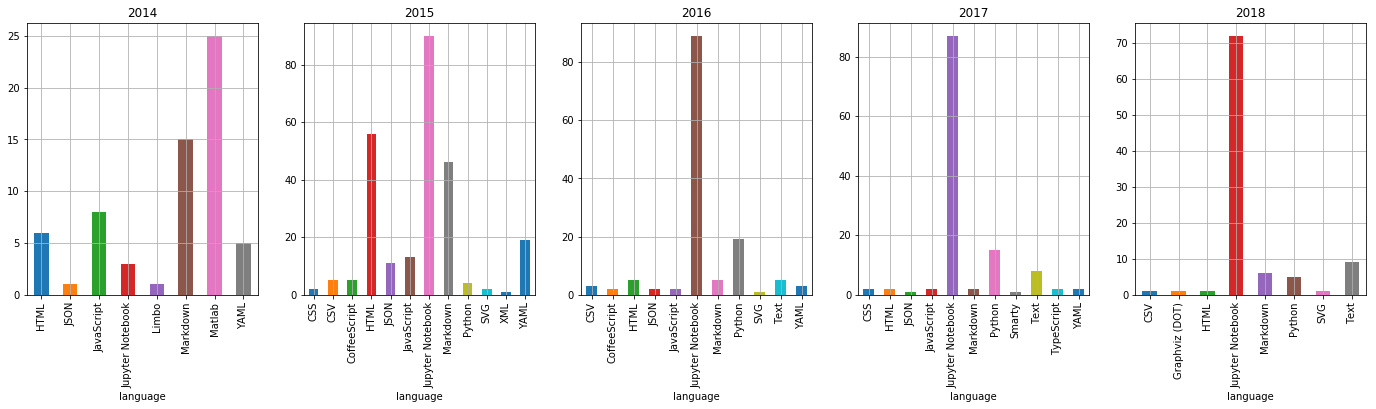

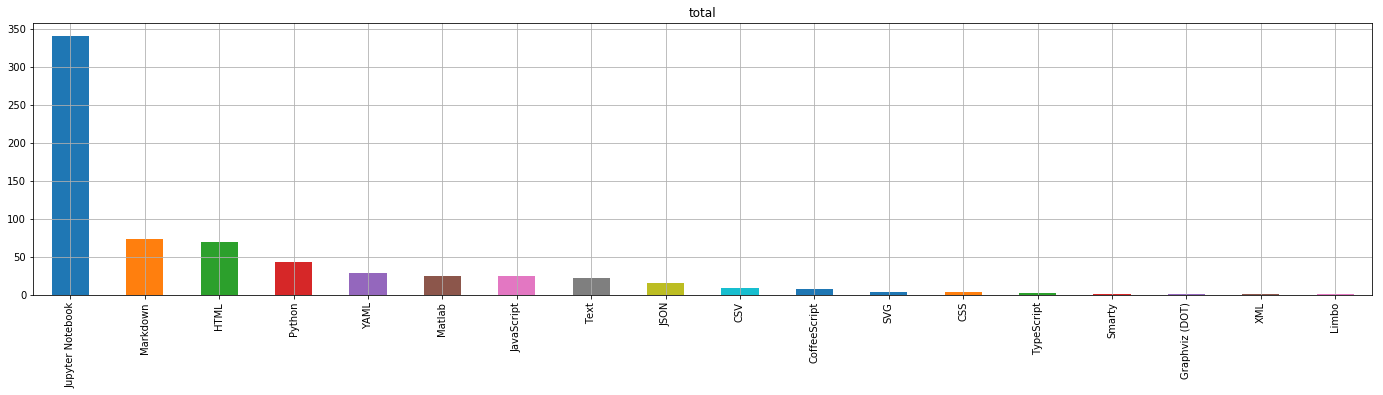

In [69]:
    subplots = pandas.Series(matplotlib.pyplot.subplots(1, len(languages), figsize=(24, 5))[1], languages.index)
    
    languages.apply(
        lambda s: s.dropna().plot.bar(title=s.name, ax=subplots.loc[s.name], grid=True), axis=1)
    matplotlib.pyplot.show()
    (gist.language
     .value_counts()
     .plot.bar(title='total', grid=True, figsize=(24, 5)))

# What the hell just happened?

In [70]:
    import ast, nbconvert

In [71]:
    attributes = pandas.Series()
    class FindAttributes(ast.NodeVisitor):
        def visit_Attribute(self, node):   self.attributes[-1].append(node.attr) or super().generic_visit(node)
                        
        def visit_Name(self, node):  
            value = globals().get(node.id, None)
            self.attributes[-1].append(
                type(value).__name__ if isinstance(value, (pandas.DataFrame, pandas.Series)) else node.id
            ) or super().generic_visit(node)

        def __call__(self, str):
            self.attributes = list()
            for body in ast.parse(str).body:
                self.attributes.append([])
                self.visit(body)
                self.attributes[-1] = ', '.join(reversed(self.attributes[-1]))
            return pandas.Series(self.attributes).pipe(lambda s: s[s.apply(bool)])
    actions = FindAttributes()(nbconvert.get_exporter('python')().from_filename(filename='demo.ipynb')[0].replace('await ', ''))

A back of the envelope use of attributes in this demonstation.

In [74]:
    actions.str.split(
        ',', expand=True
    ).stack().str.strip().str.lower().value_counts().to_frame().T

,series,dataframe,pandas,set_index,pipe,index,str,df,plot,self,...,globals,events_url,loc,valueerror,venn3_unweighted,public_repos,filter,endswith,to_series,nodevisitor
0,41,35,34,10,10,10,9,8,8,8,...,1,1,1,1,1,1,1,1,1,1


# A summary

* `pandas.DataFrame.applymap` apply a function to every value.
* `pandas.DataFrame.apply` apply a function to series along an axis.
* `pandas.DataFrame.pipe` apply a function to an entire dataframe.
* `pandas.Series.apply` apply a function to each value in a series.
* `pandas.Series.pipe` apply a function to an entire series.
* `pandas.Index.map` apply a function to each value in an index.
* `pandas.Index.to_series` convert an index to a series.
* `pandas.Index.to_frame` convert an index to a dataframe.

👉 [Extending pandas](extending.ipynb)
